In [1]:
# !pip install pip --upgrade
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import pandas as pd
# !pip install pyopenssl --upgrade
# !pip install --upgrade smart_open
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# for processing
import re
import nltk
from nltk.tokenize import word_tokenize


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

from datetime import datetime
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import numpy as np
import pandas as pd

In [2]:
%%time
embeddings_dict_6B_50D = {}
with open("glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-50]).lower().strip()
        vector = np.asarray(values[-50:], "float32")
        embeddings_dict_6B_50D[word] = vector
        
def vectorize_text_50(text):
    vectors = [embeddings_dict_6B_50D.get(word) for word in str(text).split() if word in embeddings_dict_6B_50D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(50)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 4.12 s


In [3]:
%%time
embeddings_dict_6B_100D = {}
with open("glove.6B/glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-100]).lower().strip()
        vector = np.asarray(values[-100:], "float32")
        embeddings_dict_6B_100D[word] = vector
        
def vectorize_text_100(text):
    vectors = [embeddings_dict_6B_100D.get(word) for word in str(text).split() if word in embeddings_dict_6B_100D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(100)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 7.52 s


In [4]:
def text_normalizer(text):
    if text:
        # Use NLTK RegexpTokenizer for tokenization. 
        # This tokenizer splits the text by white space and also keeps tokens like "wasn't" and "don't".
        tokenizer = RegexpTokenizer(r'\b\w[\w\'-]*\w\b|\w')
        words = tokenizer.tokenize(text)

        # Clean up any token with repeating characters like '666', 'aaa', '!!!!!!', substitute them with empty string ''.
        # This includes 'XXXX' maskings in the text created by CFPB.
        words = [re.sub(r'(\w)\1{2,}', '', word) if re.search(r'(\w)\1{2,}', word) else word for word in words]

        # Convert to lowercase and remove punctuations.
        words = [word.lower().strip() for word in words]

        # Substitute the tokens with "" where they are just numbers.
        words = ['' if word.isdigit() else word for word in words]

        # Join the words back into a single string.
        text = ' '.join([word for word in words if word])
    
    return text

In [5]:
%%time
cfpb_df = pd.read_csv("CFPB with Duplicate Marked NEW.csv")
print(cfpb_df.shape)

<timed exec>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


(1300361, 24)
Wall time: 24.8 s


In [6]:
# Drop duplicates based on 'dupi_id' column
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

(1083240, 24)


<AxesSubplot:ylabel='Frequency'>

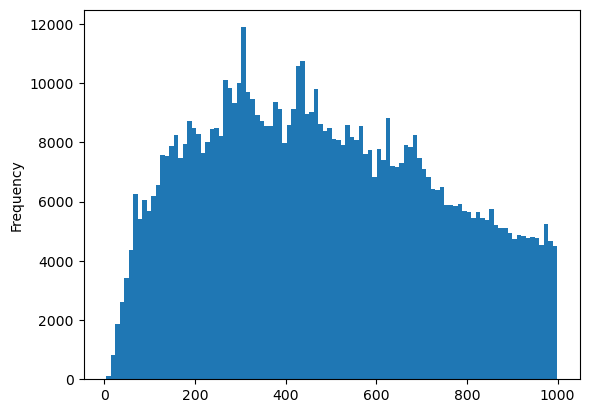

In [7]:
cfpb_df[cfpb_df['narr_len']<1000]['narr_len'].plot(kind='hist', bins=100) 

In [8]:
cfpb_df[(cfpb_df['narr_len']<300)&(cfpb_df['narr_len']>200)].sample(10)[['Consumer complaint narrative','Product']]

,Consumer complaint narrative,Product
1122514,"Wells Fargo closed all of their accounts with XXXX XXXX. This left all customers with a negative line of credit and a reduction of credit score ( for me ) of XXXX points. This damage has, no doubt, cost XXXX people XXXX dollars in damage.",Credit card
1067360,"Per FCRA, I am requesting the method of verification for nine accounts there were previously verfied. Per FCRA i have requested method of verification and procedure used to verfiy. This is my right per FCRA 611. Anyone can say verify with no back up proof that the FCRA rules were followed.","Credit reporting, credit repair services, or other personal consumer reports"
1099468,I have received a notice about my credit report with a debt on there that did not look right. Tried to call the company and speak to them directly and the phone number provide is no longer in service. I would like to get this removed and investigated.,Debt collection
91045,"On XX/XX/2020 I placed three orders on Wayfair.com using Wayfair Card. The orders were cancel next day ( more than month ago ) and never received, but refunds for those orders weren't processed and I've been charged a late fee for orders I've never received. \n\nXXXX XXXX",Credit card or prepaid card
693080,I got pre approved and was never informed in the advertisement that it was a title loan service and I would like the inquiry removed when I called the location as advised they where combative and careless.,Credit card or prepaid card
1258748,"I have been trying to apply for college loans and have been unsuccessful. Upon inquiring about my credit score, I have found XXXX different times when there are large charges under my name from the following companies : XXXX ( XXXX ), XXXX, and XXXX.",Credit reporting
280136,"XXXX has been irresponsible to correct information on my credit report. I have contacted them by phone, by their web page ( dispute an error ) and by letter. \nI have sent all documents and they still havent change the error. \nThis is related with cfpb complain # XXXX about XXXX XXXX XXXX XXXX XXXX.","Credit reporting, credit repair services, or other personal consumer reports"
1095251,"There was a numerous transactions made through Coinbase.com that would Flagg suspicious activity, and they aloud such transactions. \nAll details, dates and any information is included on the attached letter. \nThank you XXXX XXXX.","Money transfer, virtual currency, or money service"
97499,Opted Out of Getting Prescreened Offers for life. Discover and XXXX XXXX regularly send offers. I do not have any business relationship with either. Most recent offer from discover was on XX/XX/2022 via USPS. Please contact for further details.,Credit card or prepaid card
1202075,I have initially wrote to remove this company however they keep reporting back to my credit. \nSummary of your complaint Complaint number : XXXX Date submitted to CFPB : XX/XX/2017 Date sent to company : XX/XX/2017 Product : Debt collectionIssue : Attempts to collect debt not owed,Debt collection


In [9]:
cfpb_df['narr_len'].quantile(.16)

274.0

In [10]:
cfpb_df[(cfpb_df['narr_len']>500)].Product.value_counts(normalize=True)

Credit reporting, credit repair services, or other personal consumer reports    0.365905
Debt collection                                                                 0.159558
Mortgage                                                                        0.125267
Credit card or prepaid card                                                     0.099491
Checking or savings account                                                     0.070329
Student loan                                                                    0.037997
Money transfer, virtual currency, or money service                              0.030780
Vehicle loan or lease                                                           0.024538
Credit reporting                                                                0.020711
Credit card                                                                     0.019691
Bank account or service                                                         0.016438
Payday loan, title lo

In [11]:
import pandas as pd

# define a dictionary to map the old categories to the new ones
category_mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit reporting and repair services",
    "Credit reporting": "Credit reporting and repair services",
    "Credit card or prepaid card": "Credit and prepaid cards",
    "Credit card": "Credit and prepaid cards",
    "Prepaid card": "Credit and prepaid cards",
    "Checking or savings account": "Banking services",
    "Bank account or service": "Banking services",
    "Money transfer, virtual currency, or money service": "Money transfer and virtual currency services",
    "Money transfers": "Money transfer and virtual currency services",
    "Virtual currency": "Money transfer and virtual currency services",
    "Vehicle loan or lease": "Loans and leases",
    "Consumer Loan": "Loans and leases",
    "Payday loan, title loan, or personal loan": "Short-term and personal loans",
    "Payday loan": "Short-term and personal loans",
    "Other financial service": "Other financial service",
    "Mortgage": "Mortgage",
    "Student loan": "Student loan",
    "Debt collection": "Debt collection"
}

# apply the mapping to the 'product' column
cfpb_df['combined_product'] = cfpb_df['Product'].map(category_mapping)
cfpb_df[(cfpb_df['narr_len']>500)].combined_product.value_counts(normalize=True)

Credit reporting and repair services            0.386616
Debt collection                                 0.159558
Mortgage                                        0.125267
Credit and prepaid cards                        0.120523
Banking services                                0.086766
Student loan                                    0.037997
Loans and leases                                0.034030
Money transfer and virtual currency services    0.032370
Short-term and personal loans                   0.016557
Other financial service                         0.000315
Name: combined_product, dtype: float64

In [12]:
cfpb_df[(cfpb_df['narr_len']>500)].Issue.value_counts(normalize=True)

Incorrect information on your report                                                0.169788
Problem with a credit reporting company's investigation into an existing problem    0.124937
Improper use of your report                                                         0.063097
Attempts to collect debt not owed                                                   0.058989
Trouble during payment process                                                      0.041716
                                                                                      ...   
Shopping for a line of credit                                                       0.000006
Problem with an overdraft                                                           0.000004
Lender sold the property                                                            0.000004
Lender damaged or destroyed vehicle                                                 0.000003
Lender damaged or destroyed property                                  

In [13]:
cfpb_df[(cfpb_df['narr_len']>500)].shape

(698023, 25)

In [14]:
cfpb_df.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'clean_narr', 'dupi_id', 'dupi_len',
       'combined_product'],
      dtype='object')

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

def plot_proba_distribution(y_pred_proba, classes):
    for idx, _class in enumerate(classes):
        sns.kdeplot(y_pred_proba[:, idx], label=_class)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Probability distributions of classes')
    plt.legend()
    plt.show()

def grid_search_svm(df, column_name):
    for unique_value in df[column_name].unique():
        print(f"now training binary classification model for {unique_value}")
        # create target
        df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
        print(df['is_'+ unique_value].value_counts())
        
        # vectorize
        df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_50)
        
        # create x and y
        X = list(df['glove_50_features'])
        y = df['is_'+ unique_value]
        
        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
        # Apply Balancing with ADASYN
        # ada = ADASYN(random_state=42)
        # X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)
        rus = RandomUnderSampler(random_state=42)
        X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X_train).tolist(), y_train)
        
        for data_size in [5000, 10000, 50000]:
            # Randomly select x samples for training
            sample_idx = np.random.choice(len(X_train_resampled), data_size, replace=False)
            X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
            y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]
            
            # grid search
            param_grid = {'C': [250, 500, 750], 'gamma': [0.25, 0.5, 0.75, 0.99], 'kernel': ['rbf']}
            
            # initialize svm and grid
            svm = SVC(class_weight='balanced')
            svm.classes_ = np.array([0, 1])
            grid = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=3, n_jobs=-1)
            # fitting the grid
            grid.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)
            
            # evaluate
            y_pred = grid.predict(np.array(X_test).tolist())
            print(classification_report(y_test, y_pred))
            print("The best parameters:", grid.best_params_)
            print("Data size:", data_size)

            results = grid.cv_results_
            for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
                print(params, "has a score of", mean_test_score)
            print("-----------------------------------------------------------------------")
        print("**************************************************************************")
        
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
def grid_search_svm(df, column_name):
    for unique_value in df[column_name].unique():
        if True:
#         if unique_value in ['Checking or savings account', 
#                             "Money transfer, virtual currency, or money service", 
#                             'Debt collection']:
            try:
                print(f"now training binary classification model for {unique_value}")
                # create target
                df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
                print(df['is_'+ unique_value].value_counts())

                # vectorize
                df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_50)

                # create x and y
                X = list(df['glove_50_features'])
                y = df['is_'+ unique_value]

                # split data
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

                # Apply Balancing with ADASYN
                # ada = ADASYN(random_state=42)
                # X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)
                rus = RandomUnderSampler(random_state=42)
                X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X_train).tolist(), y_train)
                print(y_train_resampled.value_counts())

                for data_size in [5000, 10000]:#, 10000, 20000]:
                    # Randomly select x samples for training
                    sample_idx = np.random.choice(len(X_train_resampled), data_size, replace=False)
                    X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
                    y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

                    # grid search
                    param_grid = {'C': [250, 500, 750], 'gamma': [0.25, 0.5, 0.75, 0.99], 'kernel': ['rbf']}

                    # initialize svm and grid
                    svm = SVC(class_weight='balanced')
                    svm.classes_ = np.array([0, 1])
                    grid = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=4, n_jobs=-1)
                    # fitting the grid
                    grid.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)

                    # evaluate
                    y_pred = grid.predict(np.array(X_test).tolist())
                    print(f1_score(y_test, y_pred, average='weighted'))
                    print(classification_report(y_test, y_pred))
                    print("The best parameters:", grid.best_params_)
                    print("Data size:", data_size)

                    results = grid.cv_results_
                    for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
                        print(params, "has a score of", mean_test_score)
                    print("-----------------------------------------------------------------------")
                print("**************************************************************************")
            except:
                pass

In [16]:
grid_search_svm(cfpb_df, "combined_product")

now training binary classification model for Credit reporting and repair services
0    603908
1    479332
Name: is_Credit reporting and repair services, dtype: int64
0    431471
1    431471
Name: is_Credit reporting and repair services, dtype: int64
Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.8523399058548902
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     60463
           1       0.83      0.84      0.83     47861

    accuracy                           0.85    108324
   macro avg       0.85      0.85      0.85    108324
weighted avg       0.85      0.85      0.85    108324

The best parameters: {'C': 250, 'gamma': 0.25, 'kernel': 'rbf'}
Data size: 5000
{'C': 250, 'gamma': 0.25, 'kernel': 'rbf'} has a score of 0.8453855378878083
{'C': 250, 'gamma': 0.5, 'kernel': 'rbf'} has a score of 0.8296255939587663
{'C': 250, 'gamma': 0.75, 'kernel': 'rbf'} has a score of 0.8228808003995572
{'C': 250, 'gamma': 0.99, 'kernel

0.8800293591362479
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    100086
           1       0.33      0.89      0.48      8238

    accuracy                           0.85    108324
   macro avg       0.66      0.87      0.70    108324
weighted avg       0.94      0.85      0.88    108324

The best parameters: {'C': 250, 'gamma': 0.25, 'kernel': 'rbf'}
Data size: 10000
{'C': 250, 'gamma': 0.25, 'kernel': 'rbf'} has a score of 0.8710120267242502
{'C': 250, 'gamma': 0.5, 'kernel': 'rbf'} has a score of 0.8621640422252863
{'C': 250, 'gamma': 0.75, 'kernel': 'rbf'} has a score of 0.8517559980025664
{'C': 250, 'gamma': 0.99, 'kernel': 'rbf'} has a score of 0.8407305363567005
{'C': 500, 'gamma': 0.25, 'kernel': 'rbf'} has a score of 0.8675023797886696
{'C': 500, 'gamma': 0.5, 'kernel': 'rbf'} has a score of 0.8539863722528604
{'C': 500, 'gamma': 0.75, 'kernel': 'rbf'} has a score of 0.8447273937918025
{'C': 500, 'gamma': 0.99, 'kernel': 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.8401169119917338
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     97196
           1       0.33      0.84      0.47     11128

    accuracy                           0.81    108324
   macro avg       0.65      0.82      0.68    108324
weighted avg       0.91      0.81      0.84    108324

The best parameters: {'C': 250, 'gamma': 0.25, 'kernel': 'rbf'}
Data size: 10000
{'C': 250, 'gamma': 0.25, 'kernel': 'rbf'} has a score of 0.8279478101569809
{'C': 250, 'gamma': 0.5, 'kernel': 'rbf'} has a score of 0.8219961547166248
{'C': 250, 'gamma': 0.75, 'kernel': 'rbf'} has a score of 0.812464475997871
{'C': 250, 'gamma': 0.99, 'kernel': 'rbf'} has a score of 0.8037873818299712
{'C': 500, 'gamma': 0.25, 'kernel': 'rbf'} has a score of 0.8240146565440888
{'C': 500, 'gamma': 0.5, 'kernel': 'rbf'} has a score of 0.816409430378782
{'C': 500, 'gamma': 0.75, 'kernel': 'rbf'} has a score

0.9186979446833609
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    104879
           1       0.20      0.88      0.33      3445

    accuracy                           0.89    108324
   macro avg       0.60      0.89      0.63    108324
weighted avg       0.97      0.89      0.92    108324

The best parameters: {'C': 250, 'gamma': 0.25, 'kernel': 'rbf'}
Data size: 5000
{'C': 250, 'gamma': 0.25, 'kernel': 'rbf'} has a score of 0.8816488749136433
{'C': 250, 'gamma': 0.5, 'kernel': 'rbf'} has a score of 0.8799469574996304
{'C': 250, 'gamma': 0.75, 'kernel': 'rbf'} has a score of 0.873114327962187
{'C': 250, 'gamma': 0.99, 'kernel': 'rbf'} has a score of 0.8662332916096446
{'C': 500, 'gamma': 0.25, 'kernel': 'rbf'} has a score of 0.8804516647036971
{'C': 500, 'gamma': 0.5, 'kernel': 'rbf'} has a score of 0.8717592188392895
{'C': 500, 'gamma': 0.75, 'kernel': 'rbf'} has a score of 0.8642412728131669
{'C': 500, 'gamma': 0.99, 'kernel': 'r

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_proba_distribution(y_pred_proba, classes):
    for idx, _class in enumerate(classes):
        sns.kdeplot(y_pred_proba[:, idx], label=_class)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Probability distributions of classes')
    plt.legend()
    plt.show()

def grid_search_svm(df, column_name):
    

    for unique_value in df[column_name].unique():
        print(f"now training binary classification model for {unique_value}")
        # create target
        df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
        print(df['is_'+ unique_value].value_counts())
        
        # for recall for imballanced classes started to plateau at 12000 sample size
        # for data_size in [6000, 12000, 24000, 36000]:
        # for data_size in [12000, 18000]:
        for data_size in [15000]:
            df_tmp = df.sample(n=data_size, random_state=42)
            # create features
            df_tmp['glove_50_features'] = df_tmp['clean_narr'].apply(vectorize_text)

            X = list(df_tmp['glove_50_features'])
            y = df_tmp['is_'+ unique_value]

            # split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Apply SMOTE
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(np.array(X_train).tolist(), y_train)

            # initialize svm
            svm = SVC(class_weight='balanced')
            # param_grid = {'C': [250,500,750], 'gamma': [0.5, 0.7, 1], 'kernel': ['rbf']}
            # param_grid = {'C': [175, 250, 325], 'gamma': [0.5, 0.6, 0.7], 'kernel': ['rbf']}
            # param_grid = {'C': [300, 350, 400], 'gamma': [0.7, 0.75, 0.8], 'kernel': ['rbf']}
            # param_grid = {'C': [300, 350, 400], 'gamma': [0.7, 0.75, 0.8], 'kernel': ['rbf']}
            param_grid = {'C': [350], 'gamma': [0.75], 'kernel': ['rbf']}
            grid = GridSearchCV(svm, param_grid, cv=5, scoring='f1')
            
            # fitting the model
            grid.fit(np.array(X_train).tolist(), y_train)
            
            # evaluate
            y_pred = grid.predict(np.array(X_test).tolist())
            print(classification_report(y_test, y_pred))
            print("The best parameters:", grid.best_params_)
            print("Data size:", data_size)

            results = grid.cv_results_
            for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
                print(params, "has a score of", mean_test_score)

def train_svm(df, column_name):
    model_dict = {}
    for unique_value in df[column_name].unique():
        # create target
        df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
        
        
        value_counts = df['is_'+ unique_value].value_counts()
        # check if the minority class is at least 1% of the majority class
        if min(value_counts)/max(value_counts) < 0.05:
            print(f"Skipping training binary classification model for {unique_value} due to class imbalance.")
            continue
        print(value_counts)
        print(f"now training binary classification model for {unique_value}")
        
#         df_tmp = df.sample(n=15000, random_state=42).copy()
#         # create features
#         df_tmp['glove_50_features'] = df_tmp['clean_narr'].apply(vectorize_text_50)

#         X = list(df_tmp['glove_50_features'])
#         y = df_tmp['is_'+ unique_value]

#         # split data
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#         # Apply SMOTE
#         # sm = SMOTE(random_state=42)
#         # X_train, y_train = sm.fit_resample(np.array(X_train).tolist(), y_train)
#         ada = ADASYN(random_state=42)
#         X_train, y_train = ada.fit_resample(np.array(X_train).tolist(), y_train)
        # create features
        df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_50)

        X = list(df['glove_50_features'])
        y = df['is_'+ unique_value]

#         # Apply ADASYN
#         ada = ADASYN(random_state=42)
#         X_resampled, y_resampled = ada.fit_resample(np.array(X).tolist(), y)

#         # Randomly select 15000 samples for training
#         sample_idx = np.random.choice(len(X_resampled), 15000, replace=False)
#         X_resampled_sampled = [X_resampled[i] for i in sample_idx]
#         y_resampled_sampled = [y_resampled[i] for i in sample_idx]

#         # split data
#         X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.1, random_state=42)


        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

        # Apply ADASYN
        ada = ADASYN(random_state=42)
        X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)

        # Randomly select 15000 samples for training
        # Randomly select 15000 samples for training
        sample_idx = np.random.choice(len(X_train_resampled), 30000, replace=False)
        X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
        y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]



        # initialize svm
        svm = SVC(class_weight='balanced', C=350, gamma=0.75, kernel = 'rbf', probability=True)
        svm.classes_ = np.array([0, 1])

        # fitting the model
        svm.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)


        # evaluate
        y_pred = svm.predict(np.array(X_test).tolist())
        print(classification_report(y_test, y_pred))
        print(svm.classes_)
        
        # Get the probabilities
        y_pred_proba = svm.predict_proba(np.array(X_test).tolist())

        # Plot the distribution
        plot_proba_distribution(y_pred_proba, svm.classes_)

        model_dict[f"{unique_value}_clf"] = svm
        print("**************************************************************************")
    return model_dict

0    632832
1    450408
Name: is_Credit reporting, credit repair services, or other personal consumer reports, dtype: int64
now training binary classification model for Credit reporting, credit repair services, or other personal consumer reports
              precision    recall  f1-score   support

           0       0.88      0.81      0.84     63297
           1       0.76      0.85      0.80     45027

    accuracy                           0.83    108324
   macro avg       0.82      0.83      0.82    108324
weighted avg       0.83      0.83      0.83    108324

[0 1]


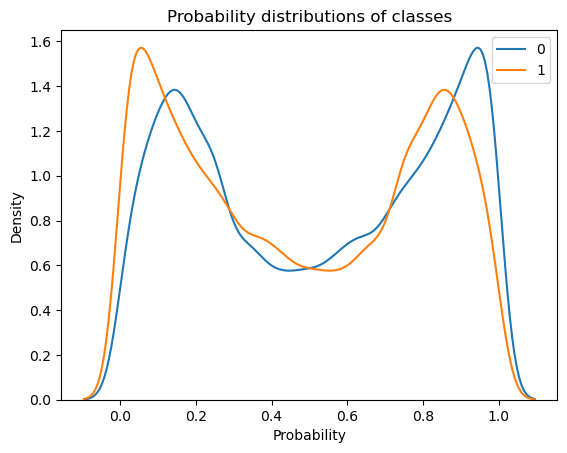

**************************************************************************
Skipping training binary classification model for Money transfer, virtual currency, or money service due to class imbalance.
0    1016747
1      66493
Name: is_Checking or savings account, dtype: int64
now training binary classification model for Checking or savings account
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    101598
           1       0.31      0.83      0.45      6726

    accuracy                           0.87    108324
   macro avg       0.65      0.85      0.69    108324
weighted avg       0.95      0.87      0.90    108324

[0 1]


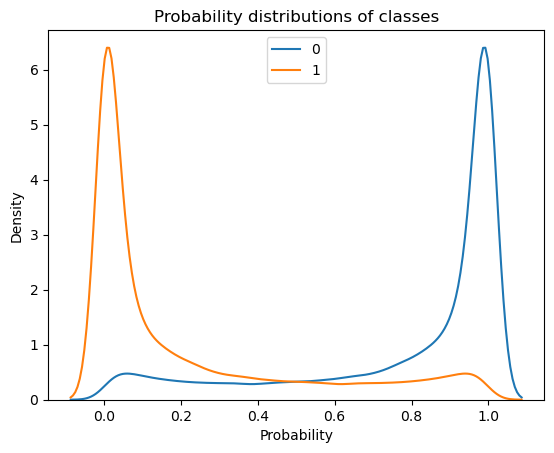

**************************************************************************
0    892097
1    191143
Name: is_Debt collection, dtype: int64
now training binary classification model for Debt collection
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     89145
           1       0.47      0.79      0.59     19179

    accuracy                           0.81    108324
   macro avg       0.71      0.80      0.73    108324
weighted avg       0.86      0.81      0.82    108324

[0 1]


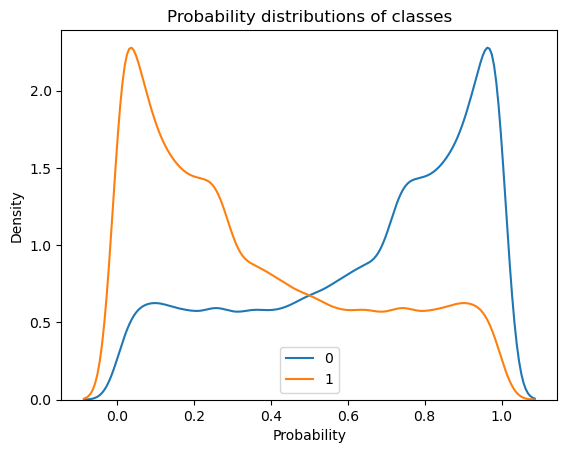

**************************************************************************
0    979591
1    103649
Name: is_Mortgage, dtype: int64
now training binary classification model for Mortgage


In [ ]:
# grid_search_svm(cfpb_df, "Product")
product_models = train_svm(cfpb_df, "Product")

In [ ]:
cfpb_df_long = cfpb_df[cfpb_df['narr_len']>275].copy()
long_product_models = train_svm(cfpb_df_long, "Product") # Did'nt see huge improvements

In [ ]:
issue_models = train_svm(cfpb_df, "Issue")

In [ ]:
long_issue_models = train_svm(cfpb_df_long, "Issue") # see improvements

In [70]:
import pickle
# Save each model
for model_name, model in product_models.items():
    filename = f"Product {model_name}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [71]:
# for model_name, model in long_product_models.items():
#     filename = f"Product {model_name} long.pkl"
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)

In [72]:
# for model_name, model in issue_models.items():
#     filename = f"Issue {model_name}.pkl"
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)

In [73]:
for model_name, model in long_issue_models.items():
    filename = f"Issue {model_name} long.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [74]:
vectorized_text = vectorize_text("i called the collection agency for my debt verification. but they cant verify it. and it wasnt on their system. and said that they will remove it on my credit report. its been 2 months i believe but its still shows on my credit as open and with negative information.")

x = product_models['Credit reporting, credit repair services, or other personal consumer reports_clf'].predict_proba([vectorized_text])
print(x)

[[0.65038987 0.34961013]]


In [1]:
%%time
# Convert the 'date' column to datetime format
print("Before droping nan narrative: ", len(cfpb_df))
cfpb_df.dropna(subset=['Consumer complaint narrative'], inplace=True)
cfpb_df['Date received'] = pd.to_datetime(cfpb_df['Date received'])
cfpb_df['narr_len'] = cfpb_df['Consumer complaint narrative'].apply(lambda x:len(str(x)))
cfpb_df['days_to_today'] = (datetime.now().date() - cfpb_df['Date received'].dt.date).dt.days

cfpb_df['narr_len'] = cfpb_df['narr_len'].astype(int)
cfpb_df['days_to_today'] = cfpb_df['days_to_today'].astype(int)

cfpb_df['days_to_today'] = (datetime.now().date() - cfpb_df['Date received'].dt.date).dt.days

cfpb_df['clean_narr'] = cfpb_df['Consumer complaint narrative'].apply(text_normalizer)
cfpb_df['narr_head_vec'] = cfpb_df['clean_narr'].apply(lambda x: vectorize_text(x[:500]))

print("After droping nan narrative: ", len(cfpb_df))

NameError: name 'cfpb_df' is not defined

In [2]:
# df = cfpb_df[cfpb_df['Complaint ID'].isin([5830282,5830057,5830027,5830056])].copy()#sample(15)
# df

In [3]:
# from scipy.spatial.distance import pdist, squareform
# vectors = df['narr_head_vec'].tolist()

# vectors_2d = np.vstack(vectors)
# dists = pdist(vectors_2d, metric='euclidean')
# dist_matrix = squareform(dists)
# pd.DataFrame(dist_matrix)

In [4]:
# point1 = df['narr_head_vec'].to_list()[0]
# point2 = df['narr_head_vec'].to_list()[1]
# point3 = df['narr_head_vec'].to_list()[2]
# point4 = df['narr_head_vec'].to_list()[3]
# point5 = cfpb_df['narr_head_vec'].sample().to_list()[0]

# print(np.linalg.norm(point1 - point2))
# print(np.linalg.norm(point1 - point3))
# print(np.linalg.norm(point1 - point5))

In [5]:
small_cfpb_df = cfpb_df[['State', 'ZIP code','Complaint ID','narr_len', 'days_to_today','narr_head_vec']].copy()
small_cfpb_df[['State', 'ZIP code']] = small_cfpb_df[['State', 'ZIP code']].fillna('')

NameError: name 'cfpb_df' is not defined

In [ ]:
# when running group by, the input is a mini dataframe with same ['Product', 'Issue', 'State', 'ZIP code']
def find_duplicate_narr(df):
    small_df = df[['Complaint ID','narr_len', 'days_to_today', 'narr_head_vec']].copy()
    
    def find_dupi_in_small_df(row_narr_len, row_to_day, row_narr_head_vec, small_df):
        tmp_df = small_df.query("narr_len <= @row_narr_len*1.2 & narr_len >= @row_narr_len*0.8 & days_to_today <= @row_to_day+5 & days_to_today >= @row_to_day-5").copy()    
        tmp_df['eclidean_dist'] = tmp_df['narr_head_vec'].apply(lambda x: np.linalg.norm(x - row_narr_head_vec))
        dupli_df = tmp_df[tmp_df['eclidean_dist']<0.25]
        dupli_id_list = sorted(dupli_df['Complaint ID'].to_list())
        return dupli_id_list
    
    df['dupi_id'] = small_df.apply(lambda row: find_dupi_in_small_df(row['narr_len'], int(row['days_to_today']), row['narr_head_vec'], small_df),axis=1)
    
    return df

In [ ]:
%%time
small_cfpb_df = small_cfpb_df.groupby(['State', 'ZIP code']).apply(func=find_duplicate_narr)

In [ ]:
small_cfpb_df['dupi_len'] = small_cfpb_df['dupi_id'].apply(lambda x: len(x))
small_cfpb_df['dupi_id'] = small_cfpb_df['dupi_id'].apply(lambda x: ";".join([str(y) for y in x]))

In [ ]:
merged_df = cfpb_df.merge(small_cfpb_df[['Complaint ID', 'dupi_id', 'dupi_len']], on='Complaint ID', how='left').drop(['narr_head_vec'], axis=1)

In [ ]:
dupli_df = merged_df[merged_df.dupi_len>1].sort_values('dupi_id').copy()
dupli_df

In [ ]:
df = dupli_df.groupby(['Product','dupi_id']).sum().reset_index()
df['dupi_id_len'] = df['dupi_id'].apply(lambda x: len(x.split(";")))
df[df['dupi_id_len']!=np.sqrt(df['dupi_len'])].sort_values('days_to_today')

In [ ]:
pivot_table = pd.pivot_table(dupli_df, index='dupi_len', columns='Product', aggfunc=len, fill_value=0)
pivot_table

In [ ]:
dupli_df['narr_len'] = dupli_df['narr_len'].apply(lambda x: round(x, -2))
pivot_table = pd.pivot_table(dupli_df, index='dupi_len', columns='narr_len', aggfunc=len, fill_value=0)
pivot_table

In [ ]:
dupli_df[dupli_df.dupi_len>25]

In [ ]:
merged_df.to_csv('CFPB with Duplicate Marked NEW.csv')

In [ ]:
cdpb = cfpb.sample(200000, random_state=42)

##### We dont remove stop words,  perform lemmatization or stemmingfor GloVe
Context: GloVe vectors capture the context of words by considering their co-occurrences with other words. Removing stopwords might lead to loss of some context, especially for tasks where the semantics of the full sentence are important. For instance, in sentiment analysis, removing stopwords could potentially alter the sentiment of a sentence.

Semantic Meaning: Some stopwords carry semantic meaning. For instance, the word "not" is generally considered a stopword, but it is also a negation word that can completely reverse the meaning of a sentence. If you remove it, you might change the meaning of your data.

Word Frequency: GloVe vectors are trained on a corpus where the stopwords are usually not removed. As a result, the embeddings for these words can capture useful semantic and syntactic relationships because of their high frequency of occurrence.

Dimensionality: On the other hand, removing stopwords can help in reducing the dimensionality of your data and might make your model faster and more efficient, especially if you have a very large corpus.


Lemmatization and stemming are techniques used to reduce words to their root form. These techniques can be useful for certain tasks where you want to treat different inflections of a word (like "run", "running", "runs") as the same word. However, when using pre-trained word embeddings like GloVe, you should be aware that the embeddings for the original words and their stemmed/lemmatized versions are not the same, and in some cases, the stemmed/lemmatized version might not even be in the vocabulary.

Additionally, lemmatization and stemming can sometimes change the meaning of the word or make it lose its context. For instance, the word "meeting" can be a verb (as in "I am meeting my friends") or a noun (as in "I have a meeting"). If you stem it to "meet", it might lose this contextual information.

In [ ]:
from nltk.tokenize import RegexpTokenizer

def text_normalizer(text):
    if text:
        # Use NLTK RegexpTokenizer for tokenization. 
        # This tokenizer splits the text by white space and also keeps tokens like "wasn't" and "don't".
        tokenizer = RegexpTokenizer(r'\b\w[\w\'-]*\w\b|\w')
        words = tokenizer.tokenize(text)

        # Clean up any token with repeating characters like '666', 'aaa', '!!!!!!', substitute them with empty string ''.
        # This includes 'XXXX' maskings in the text created by CFPB.
        words = [re.sub(r'(\w)\1{2,}', '', word) if re.search(r'(\w)\1{2,}', word) else word for word in words]

        # Convert to lowercase and remove punctuations.
        words = [word.lower().strip() for word in words]

        # Substitute the tokens with "" where they are just numbers.
        words = ['' if word.isdigit() else word for word in words]

        # Join the words back into a single string.
        text = ' '.join([word for word in words if word])
    
    return text

In [ ]:
%%time
cfpb['clean_narr'] = cfpb['Consumer complaint narrative'].apply(text_normalizer)
cfpb

In [ ]:
def vectorize_text(text):
    vectors = [embeddings_dict_6B_50D.get(word) for word in str(text).split() if word in embeddings_dict_6B_50D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(50)  # if there are no vectors, return a zero-vector
    return vectorized

In [ ]:
vectorized_texts = cfpb['clean_narr'].apply(vectorize_text)

# convert vectorized_texts into a DataFrame
vector_df = pd.DataFrame(vectorized_texts.tolist(), columns=[f'glove_{i}' for i in range(1, 51)])

# reset the index of both DataFrames to ensure proper concatenation
cfpb = cfpb.reset_index(drop=True)
vector_df = vector_df.reset_index(drop=True)

# concatenate the original DataFrame cfpb and vector_df
cfpb = pd.concat([cfpb, vector_df], axis=1)

In [ ]:
cfpb.sample(5)

In [ ]:
cfpb.Product.value_counts()

In [ ]:
cfpb['is_debt_collection'] = cfpb.Product.apply(lambda x: 1 if x=='Debt collection' else 0)

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'is_debt_collection' is the column that specifies if a complaint is about debt collection
y = cfpb['is_debt_collection']
X = cfpb.loc[:, 'glove_1':'glove_50']  # Extract only the GloVe vector columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced')

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1')

grid.fit(X_train_smote, y_train_smote)

In [ ]:
from sklearn.metrics import classification_report

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

# Print the mean test scores and parameters for each iteration
results = grid.cv_results_
for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
    print(params, "has a score of", mean_test_score)

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the model with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the hyperparameters
# param_grid = {
#     'n_estimators': [50, 70, 100],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth' : [4,6,8],
#     'criterion' :['gini', 'entropy']
# }
# # best is {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 70} has a score of 0.36957725010492326

param_grid = {
    'n_estimators': [70, 100, 125],
    'max_features': ['sqrt'],
    'max_depth' : [8,10,12],
    'criterion' :['gini']
}

# Perform hyperparameter tuning
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

# Evaluate your model
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

# Perform hyperparameter tuning
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

# Print the mean test scores and parameters for each iteration
results = grid.cv_results_
for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
    print(params, "has a score of", mean_test_score)


In [ ]:
%%time
from sklearn.svm import SVC
from sklearn.utils import class_weight

# Define the model with class weights
svm = SVC(class_weight='balanced')

# # Define the hyperparameters
# param_grid = {'C': [0.01, 0.1, 1, 10], 
#               'gamma': [1, 0.01, 0.0001],
#               'kernel': ['linear', 'poly', 'rbf']}
# # best is about 0.5

# param_grid = {'C': [10,50,100], 
#               'gamma': [1, 0.8, 0.9],
#               'kernel': ['rbf']}
# # {'C': 100, 'gamma': 1, 'kernel': 'rbf'} has a score of 0.5484671199176903

# param_grid = {'C': [100,500,1000], 
#               'gamma': [1],
#               'kernel': ['rbf']}
# # {'C': 500, 'gamma': 1, 'kernel': 'rbf'} has a score of 0.5564294078533358

param_grid = {'C': [250,500,750], 
              'gamma': [0.5, 1],
              'kernel': ['rbf']}

# Perform hyperparameter tuning
grid = GridSearchCV(svm, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

# Evaluate your model
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

# Print the mean test scores and parameters for each iteration
results = grid.cv_results_
for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
    print(params, "has a score of", mean_test_score)

In [ ]:
!pip install xgboost

In [ ]:
%%time

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the model
xgb = XGBClassifier()

# Define the hyperparameters
# param_grid = {
#     'n_estimators': [50, 70, 100],
#     'max_depth' : [4,6,8],
#     'learning_rate' : [0.01, 0.05, 0.1]
# }
# # {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100} has a score of 0.40803526169579774

# https://amangupta16.medium.com/xgboost-hyperparameters-explained-bb6ce580501d
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'grow_policy':['depthwise', 'lossguide'],
    'learning_rate': [0.01, 0.1, 0.25, 0,5],
    'gamma': [0, 0.25, 0.5, 0.75, 1.0],
    'objective': ['binary:logistic'],
#     'booster':['gbtree', 'gblinear', 'dart'], 
#     'min_child_weight': [0, 10, 100],
#     'max_delta_step': [0, 5, 10],
#     'subsample': [0.5, 0.75, 1.0],
#     'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.1, 0.5, 1.0],
#     'reg_lambda': [0, 0.1, 0.5, 1.0],
#     'scale_pos_weight': [0.1, 0.25, 1]  
}
# {'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4600636603662126
# {'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.47833576908629316
# {'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.481646301347

# {'gamma': 0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4600636603662126
# {'gamma': 0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.47833576908629316
# {'gamma': 0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.481646301347

# {'gamma': 0.25, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4502555747462524
# {'gamma': 0.25, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.4723017880098485
# {'gamma': 0.25, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.47917677346322646

# {'gamma': 0.5, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.45447253060264303
# {'gamma': 0.5, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.4731291506961715
# {'gamma': 0.5, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.4777666298




# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4519261276161095
# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.4717137003276105
# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.4717137003276105
# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4569095910751261
# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.45770395065209435
# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.45770395065209435
# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4445592148570988
# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.4445592148570988
# {'gamma': 1.0, 'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.4445592148570988
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4519261276161095
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.4717137003276105
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.4717137003276105
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4569095910751261
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.45770395065209435
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.45770395065209435
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 100, 'objective': 'binary:logistic'} has a score of 0.4445592148570988
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 200, 'objective': 'binary:logistic'} has a score of 0.4445592148570988
# {'gamma': 1.0, 'grow_policy': 'lossguide', 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 300, 'objective': 'binary:logistic'} has a score of 0.4445592148570988
# Perform hyperparameter tuning
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

# Evaluate your model
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

# Print the mean test scores and parameters for each iteration
results = grid.cv_results_
for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
    print(params, "has a score of", mean_test_score)

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the model
gnb = GaussianNB()

# Define the hyperparameters
# Note: these values are just for example and should be adjusted for your specific problem
param_grid = {'var_smoothing': np.logspace(0,-9, num=20)}
# {'var_smoothing': 0.004281332398719396} has a score of 0.24493749460487274

# Perform hyperparameter tuning
grid = GridSearchCV(gnb, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

# Evaluate your model
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))


# Print the mean test scores and parameters for each iteration
results = grid.cv_results_
for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
    print(params, "has a score of", mean_test_score)

In [ ]:
# # !pip install --upgrade gensim
# # !pip install gensim==3.4.0
# # !pip install smart_open==1.9.0

# # we are not gonno use gensim here due to library version conflict

# # Load the GloVe model.
# glove_input_file = "glove.6B/glove.6B.50d.txt"
# word2vec_output_file = "glove.6B/gensim_glove_vectors.6B.50d.txt"
# glove2word2vec(glove_input_file, word2vec_output_file)
# glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# # Assuming your DataFrame is named df and your text column is named 'complaint'
# df = pd.DataFrame({
#     'complaint': ['This is the first complaint.', 'And this is the second one.']
# })

# # Preprocess text
# stop_words = set(stopwords.words('english'))
# df['complaint'] = df['complaint'].str.lower().apply(lambda x: ''.join(ch for ch in x if ch not in string.punctuation))
# df['complaint'] = df['complaint'].apply(lambda x: word_tokenize(x))
# df['complaint'] = df['complaint'].apply(lambda x: [word for word in x if word not in stop_words])

# # Replace each word in your 'complaint' column with its corresponding vector.
# df['complaint_vector'] = df['complaint'].apply(lambda x: [glove_model[word] if word in glove_model else np.zeros((50,)) for word in x])
